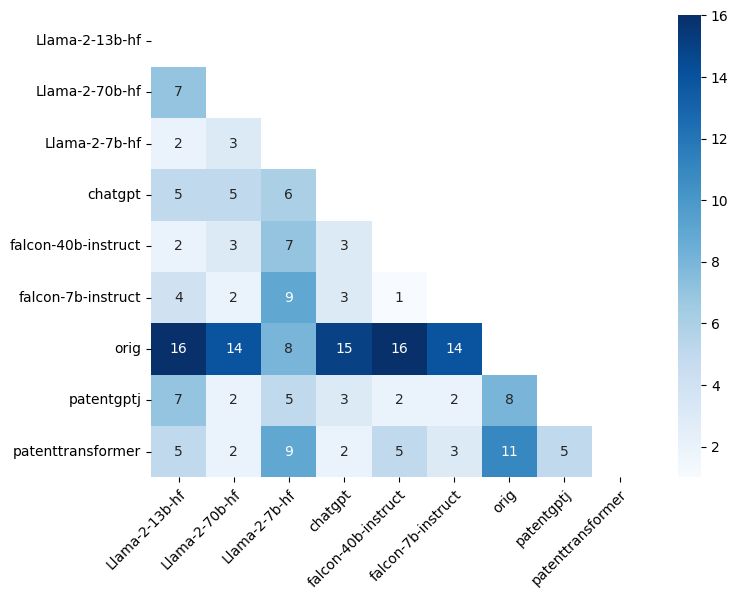

In [5]:
import json
import numpy as np
from collections import defaultdict


with open('./annotations/final_c2c.json') as f:  
    annotation_lines = json.load(f)
# keep only annotator = 13391
annotations = []
for annot in annotation_lines:
    if annot['annotator'] == 13391:
        annotations.append(annot)

with open('./preprocessed_for_annotation/selected_pairs_c2c.jsonl') as f:  model_info = [json.loads(line) for line in f]


# get model information from selected pairs
model_pairs = []
for model_selection in model_info:
    selections = list(model_selection.values())[0]
    assert len(selections) == 2
    for pair in selections:
        model_pairs.append(pair)
assert len(annotations) == len(model_pairs) # once finished, the length should be the same
model_pairs_annotated = model_pairs[:len(annotations)]


# model frequency in selected pairs
model_freq = defaultdict(int)
for pair in model_pairs:
    model1, model2 = pair
    model_freq[model1] += 1
    model_freq[model2] += 1
model_freq = dict(model_freq)


# create matrix of model pairs
model_names = list(model_freq.keys())
model_names = sorted(model_names)
count_pairs = np.zeros((len(model_names), len(model_names)))
for pair in model_pairs:
    model1, model2 = pair
    
    count_pairs[model_names.index(model1), model_names.index(model2)] += 1
    count_pairs[model_names.index(model2), model_names.index(model1)] += 1


# plot the heatmap of model pairs, only show upper triangle of the matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(count_pairs, columns=model_names, index=model_names)
mask = np.zeros_like(df)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, annot=True, fmt='.0f', cmap='Blues')
# Adjust x-tick labels
plt.xticks(np.arange(len(model_names))+0.5, model_names, rotation=45, ha="right", rotation_mode='anchor')

plt.savefig('./figures/c2c_model1_model2', dpi=300)

## Visualization of human annotations

In [6]:
with open('./annotations/final_c2c.json') as f:  
    annotation_lines = json.load(f)
# keep only annotator = 13391
annotated_data = []
for annot in annotation_lines:
    if annot['annotator'] == 13391:
        annotated_data.append(annot)

annotations = []
for annot in annotated_data:
    assert len(annot) > 0
    data_line = [annot["input_claim"], annot["output1"], annot["output2"]]
    preference = annot["comparison"][0]["selected"] if "comparison" in annot and "selected" in annot["comparison"][0] else "draw"

    errors = {}
    if "dimension1" not in annot:
        errors["dimension1"] = []
    elif "choices" in annot["dimension1"]:
        errors["dimension1"] = annot["dimension1"]["choices"]
    else:
        errors["dimension1"] = [annot["dimension1"]]

    if "dimension2" not in annot:
        errors["dimension2"] = []
    elif "choices" in annot["dimension2"]:
        errors["dimension2"] = annot["dimension2"]["choices"]
    else:
        errors["dimension2"] = [annot["dimension2"]]

    # annotations.append({"data": data_line, "preference": preference, "errors": errors})
    annotations.append({"preference": preference, "errors": errors})

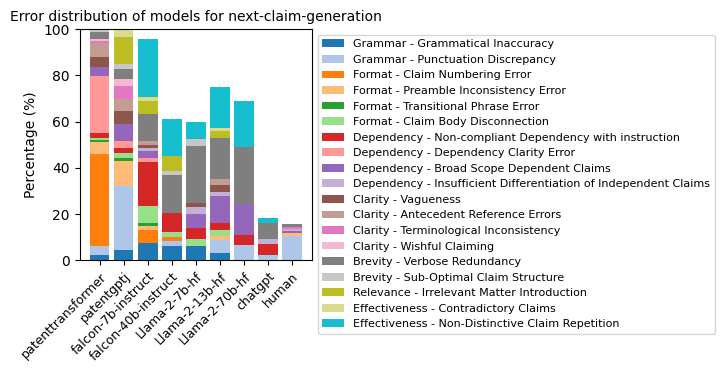

In [7]:
from collections import defaultdict

default_errors = ["Grammar - Grammatical Inaccuracy", 
                  "Grammar - Punctuation Discrepancy", 
                  # "Grammar - Antecedent Reference Errors", 
                  # "Grammar - Excessive Parentheticals",
                  "Format - Claim Numbering Error",
                  "Format - Preamble Inconsistency Error",
                  "Format - Transitional Phrase Error",
                  "Format - Claim Body Disconnection",
                  "Dependency - Non-compliant Dependency with instruction",
                  "Dependency - Dependency Clarity Error",
                  "Dependency - Broad Scope Dependent Claims",
                  "Dependency - Insufficient Differentiation of Independent Claims",
                  "Clarity - Vagueness",
                  "Clarity - Antecedent Reference Errors", 
                  "Clarity - Terminological Inconsistency",
                  "Clarity - Wishful Claiming",
                  "Brevity - Verbose Redundancy",
                  "Brevity - Sub-Optimal Claim Structure",
                  "Relevance - Irrelevant Matter Introduction",
                  "Effectiveness - Contradictory Claims",
                  "Effectiveness - Non-Distinctive Claim Repetition",
                  "Other",
                  "Correct"
                  ]
default_errors = {error: 0 for error in default_errors}

# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True
    for error in annot["errors"]["dimension1"]: 
        if "Other " not in error:
            errors[model1][error] += 1
        model1_correct = False
    for error in annot["errors"]["dimension2"]:
        if "Other " not in error:
            errors[model2][error] += 1
        model2_correct = False
    
    # if both models are correct, add 1 to correct error
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1


# calculate the frequency of each error from previous defined errors
desired_order_list = ['patenttransformer',
                      'patentgptj',
                      'falcon-7b-instruct', 
                      'falcon-40b-instruct', 
                      'Llama-2-7b-hf',
                      'Llama-2-13b-hf', 
                      'Llama-2-70b-hf',
                      'chatgpt',
                      'orig']

# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = [(k, errors[k]) for k in desired_order_list]
errors = [(model, {error: freq / sum(error_freq.values()) for error, freq in error_freq.items()}) for model, error_freq in errors]# if model != "orig"]

# change "orig" to "human"
errors = [(model.replace("orig", "human"), error_freq) for model, error_freq in errors]
############################################################################################################
# draw barchart of error ratios
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming 'error_names' contains unique types of errors
error_names = list(default_errors.keys())
error_names.remove('Other')
error_names.remove('Correct')

# Define a manual selection of distinct colors from the Tableau 20 palette
# These colors are picked for their distinctness and visual appeal
tableau20 = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
]

# Fix size of the plot
plt.figure(figsize=(3, 3))

model_names, error_freqs = zip(*errors)
error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)
# convert to percentage
error_freqs *= 100

bottom = np.zeros(len(model_names))
for i, error_name in enumerate(error_names):
    # Assign colors from the Tableau 20 palette, cycling if necessary
    color = tableau20[i % len(tableau20)]
    plt.bar(model_names, error_freqs[:, i], bottom=bottom, label=error_name, color=color)
    bottom += error_freqs[:, i]


plt.xticks(rotation=45, ha="right", rotation_mode='anchor', fontsize=9)
plt.ylabel("Percentage (%)")
plt.title("Error distribution of models for next-claim-generation", fontsize=10)

# Put legend outside of the plot on the upper left
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=8)

# Save the plot
plt.savefig('./figures/c2c_error_ratio', dpi=300)

# Show the plot
plt.show()

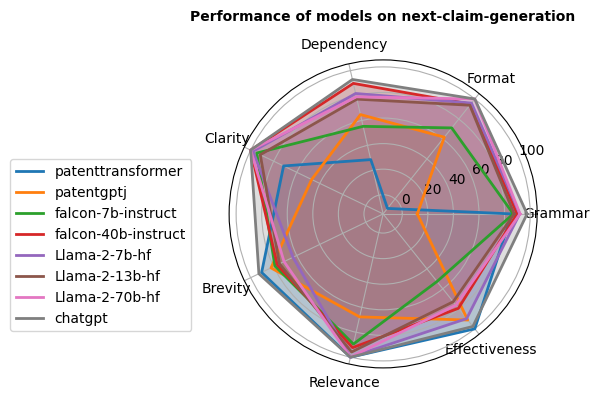

In [8]:
import matplotlib.pyplot as plt
import numpy as np


# calculate the frequency of each error from previous defined errors
errors = defaultdict(lambda: default_errors.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    model1_correct, model2_correct = True, True
    for error in annot["errors"]["dimension1"]: 
        if "Other " not in error:
            errors[model1][error] += 1
        model1_correct = False
    for error in annot["errors"]["dimension2"]:
        if "Other " not in error:
            errors[model2][error] += 1
        model2_correct = False
    
    # if both models are correct, add 1 to correct error
    if model1_correct:
        errors[model1]["Correct"] += 1
    if model2_correct:
        errors[model2]["Correct"] += 1

# calculate the frequency of each error from previous defined errors
desired_order_list = ['patenttransformer',
                      'patentgptj',
                      'falcon-7b-instruct', 
                      'falcon-40b-instruct', 
                      'Llama-2-7b-hf',
                      'Llama-2-13b-hf', 
                      'Llama-2-70b-hf',
                      'chatgpt',
                      'orig']

# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
errors = [(k, errors[k]) for k in desired_order_list]

model_names, error_freqs = zip(*errors)
error_freqs = [[error_freq.get(error, 0) for error in error_names] for error_freq in error_freqs]
error_freqs = np.array(error_freqs)
#######################################################################################
error_type_mapping = {
    "Grammar - Grammatical Inaccuracy": "Grammar",
    "Grammar - Punctuation Discrepancy": "Grammar",
    "Grammar - Antecedent Reference Errors": "Grammar", 
    # "Grammar - Excessive Parentheticals": "Grammar",
    "Format - Claim Numbering Error": "Format",
    "Format - Preamble Inconsistency Error": "Format",
    "Format - Transitional Phrase Error": "Format",
    "Format - Claim Body Disconnection": "Format",
    "Dependency - Non-compliant Dependency with instruction": "Dependency",
    "Dependency - Dependency Clarity Error": "Dependency",
    "Dependency - Broad Scope Dependent Claims": "Dependency",
    "Dependency - Insufficient Differentiation of Independent Claims": "Dependency",
    "Clarity - Vagueness": "Clarity",
    "Clarity - Antecedent Reference Errors": "Clarity", 
    "Clarity - Terminological Inconsistency": "Clarity",
    "Clarity - Wishful Claiming": "Clarity",
    "Brevity - Verbose Redundancy": "Brevity",
    "Brevity - Sub-Optimal Claim Structure": "Brevity",
    "Relevance - Irrelevant Matter Introduction": "Relevance",
    "Effectiveness - Contradictory Claims": "Effectiveness",
    "Effectiveness - Non-Distinctive Claim Repetition": "Effectiveness",
    "Correct": "Perfection"
}

new_errors = []
# Iterate through the errors data and update error type names
for i, (model, error_freq) in enumerate(errors):
    updated_error_freq = defaultdict(int)
    for error_type, freq in error_freq.items():
        updated_error_type = error_type_mapping.get(error_type, error_type)
        updated_error_freq[updated_error_type] += freq
    new_errors.append((model, updated_error_freq))


# sort the errors by model name, normalize the frequency of errors by sum of error frequency of each model
new_errors = [(model, {error: freq / model_freq[model] for error, freq in error_freq.items()}) for model, error_freq in new_errors if model != "orig"]


# Iterate through the errors data and calculate the complement (1 - error rate) for each error type except "Correct"
for i, (model, error_freq) in enumerate(new_errors):
    for error_type in error_freq:
        if error_type != "Perfection":
            new_errors[i][1][error_type] = 1 - error_freq[error_type]

new_errors = [(model, {error: round(freq * 100, 2) for error, freq in error_freq.items()}) for model, error_freq in new_errors]


# Define the error types
error_types = ["Grammar", "Format", "Dependency", "Clarity", "Brevity", "Relevance", "Effectiveness"]#, "Perfection"]

# Calculate the number of variables we're plotting.
num_vars = len(error_types)

# Compute angle each bar is centered on:
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is made circular, so we need to "complete the loop" and append the start to the end.
angles += angles[:1]

# Draw one axe per variable and add labels
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

# Helper function to draw one model on the chart.
def draw_model(ax, angles, model_name, stats):
    # Plot data and fill with color
    stats += stats[:1]  # Complete the loop
    ax.plot(angles, stats, label=model_name, linewidth=2)
    ax.fill(angles, stats, alpha=0.25)

# Iterate through each model
for model, error_freq in new_errors:
    stats = [error_freq.get(error, 0) for error in error_types]
    draw_model(ax, angles, model, stats)

# Add attribute labels
ax.set_thetagrids(np.degrees(angles[:-1]), error_types)

# Set the title of the chart
plt.title('Performance of models on next-claim-generation', fontsize=10, y=1.1, fontweight='bold')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(-0.1, 0.7), fontsize=10)

# Show plot
plt.savefig('./figures/c2c_error_polar', dpi=300)

In [9]:
# calculate the ratio of win, lose for each model compared to human and other models
default_ratios = {"win": 0, "lose": 0, "draw": 0}
compared_to_human = defaultdict(lambda: default_ratios.copy())
compared_to_models = defaultdict(lambda: default_ratios.copy())

for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    if "orig" in [model1, model2]:
        if model1 == "orig":
            if annot["preference"] == "draw":
                # # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
                # if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 1:
                #     compared_to_human[model2]["win"] += 1
                # else:
                #     compared_to_human[model2]["lose"] += 1
                compared_to_human[model2]["draw"] += 1


            elif annot["preference"] == "left":
                compared_to_human[model2]["lose"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model2]["win"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
        elif model2 == "orig":
            if annot["preference"] == "draw":
                # # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
                # if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 1:
                #     compared_to_human[model1]["win"] += 1
                # else:
                #     compared_to_human[model1]["lose"] += 1
                compared_to_human[model1]["draw"] += 1
            elif annot["preference"] == "left":
                compared_to_human[model1]["win"] += 1
            elif annot["preference"] == "right":
                compared_to_human[model1]["lose"] += 1
            else:
                print("Error in preference", annot, "in pair", (model1, model2))
    else:
        if annot["preference"] == "draw":
            # # check if there is error in this annotation according to errors, if not add 1 to win, else add 1 to lose
            # if len(annot["errors"]["dimension1"]) + len(annot["errors"]["dimension2"]) <= 1:
            #     compared_to_models[model1]["win"] += 1
            #     compared_to_models[model2]["win"] += 1
            # else:
            #     compared_to_models[model1]["lose"] += 1
            #     compared_to_models[model2]["lose"] += 1
            compared_to_models[model1]["draw"] += 1

        elif annot["preference"] == "left":
            compared_to_models[model1]["win"] += 1
            compared_to_models[model2]["lose"] += 1
        elif annot["preference"] == "right":
            compared_to_models[model1]["lose"] += 1
            compared_to_models[model2]["win"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

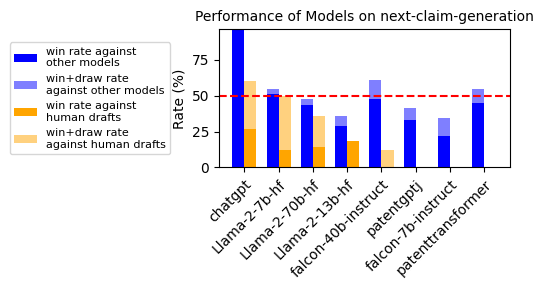

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'compared_to_models' and 'compared_to_human' contain 'win', 'draw', and 'loss' keys
# Normalize and calculate win+draw rates
normalized_models = {model: {'win': freqs['win'] / sum(freqs.values()), 
                             'draw': freqs['draw'] / sum(freqs.values())} 
                             for model, freqs in compared_to_models.items()}

normalized_human = {model: {'win': freqs['win'] / sum(freqs.values()), 
                            'draw': freqs['draw'] / sum(freqs.values())} 
                            for model, freqs in compared_to_human.items()}

# Sort models based on combined win+draw rate compared to human
sorted_models = sorted(normalized_human.items(), key=lambda x: x[1]['win'] + x[1]['draw'], reverse=True)
sorted_model_names = [model for model, _ in sorted_models]

# Extract the sorted win and draw rates
win_rates_models = [normalized_models[model]['win'] for model in sorted_model_names]
draw_rates_models = [normalized_models[model]['draw'] for model in sorted_model_names]

win_rates_human = [normalized_human[model]['win'] for model in sorted_model_names]
draw_rates_human = [normalized_human[model]['draw'] for model in sorted_model_names]

# Convert the normalized rates to percentages
win_rates_models = [rate * 100 for rate in win_rates_models]
draw_rates_models = [rate * 100 for rate in draw_rates_models]
win_rates_human = [rate * 100 for rate in win_rates_human]
draw_rates_human = [rate * 100 for rate in draw_rates_human]

#############################################################################################

barWidth = 0.35
r1 = np.arange(len(sorted_model_names))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(5.5, 3))

# Define colors and alpha for transparency
color_model = 'b'  # Blue for models
color_human = 'orange'  # Orange for humans
alpha_draw = 0.5  # Transparency for draw rate

# Plot bars for models and humans, with wins solid and draws transparent
plt.bar(r1, win_rates_models, color=color_model, width=barWidth, label='Model Win Rate')
plt.bar(r1, draw_rates_models, bottom=win_rates_models, color=color_model, width=barWidth, alpha=alpha_draw, label='Model Draw Rate')
plt.bar(r2, win_rates_human, color=color_human, width=barWidth, label='Human Win Rate')
plt.bar(r2, draw_rates_human, bottom=win_rates_human, color=color_human, width=barWidth, alpha=alpha_draw, label='Human Draw Rate')

# Add a reference line at 50% for clarity
plt.axhline(y=50, color='r', linestyle='--', label="Equilibrium Rate")

# Set the position of the x ticks and labels
plt.xticks([r + barWidth / 2 for r in r1], sorted_model_names, rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Rate (%)")
plt.title("Performance of Models on next-claim-generation", fontsize=10)

# Create the legend with clear descriptions
handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor=color_model, label='win rate against\nother models'),
    Patch(facecolor=color_model, alpha=alpha_draw, label='win+draw rate\nagainst other models'),
    Patch(facecolor=color_human, label='win rate against\nhuman drafts'),
    Patch(facecolor=color_human, alpha=alpha_draw, label='win+draw rate\nagainst human drafts')
]
plt.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(-0.15, 0.5), fontsize=8)


plt.tight_layout()
plt.savefig('./figures/c2c_win_percent', dpi=300)
plt.show()

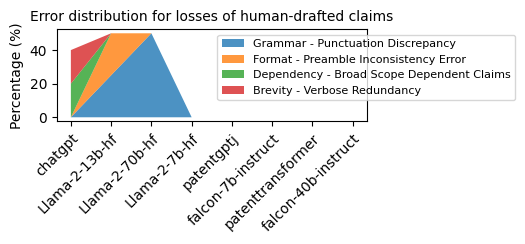

In [109]:
target_model = "orig"
stats = defaultdict(lambda: {"win+draw": 0, "lose": 0}) # count win+draw and lose to each other model
hints = {model: defaultdict(int) for model in model_freq.keys()} # every time the target model loses, count the error type that causes the loss

# count the win+draw and lose rate for each model
for (model1, model2), annot in zip(model_pairs_annotated, annotations):
    if model1 == target_model:
        if annot["preference"] == "draw":
            stats[model2]["win+draw"] += 1
        elif annot["preference"] == "right":
            stats[model2]["lose"] += 1
            for error in annot["errors"]["dimension1"]: # count the error type that causes the loss 
                hints[model2][error.split("(")[0].strip()] += 1
            if len(annot["errors"]["dimension1"]) == 0:
                hints[model2]["Correct"] += 1
                
        elif annot["preference"] == "left":
            stats[model2]["win+draw"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

    elif model2 == target_model:
        if annot["preference"] == "draw":
            stats[model1]["win+draw"] += 1
        elif annot["preference"] == "right":
            stats[model1]["win+draw"] += 1
        elif annot["preference"] == "left":
            stats[model1]["lose"] += 1
            for error in annot["errors"]["dimension2"]:
                hints[model1][error.split("(")[0].strip()] += 1
            if len(annot["errors"]["dimension2"]) == 0:
                hints[model1]["Correct"] += 1
        else:
            print("Error in preference", annot, "in pair", (model1, model2))

# normalize the win+draw and lose rate by the total number of comparison
stats = {model: {"win+draw": stats[model]["win+draw"] / (stats[model]["win+draw"] + stats[model]["lose"]),
                    "lose": stats[model]["lose"] / (stats[model]["win+draw"] + stats[model]["lose"])} for model in stats}

# sort the models by lose rate
sorted_models = sorted(stats.items(), key=lambda x: x[1]["lose"], reverse=True)
sorted_model_names = [model for model, _ in sorted_models]

# normalize the error hints by the total number of errors towards each model\
hints = {model: {error: hints[model][error] / sum(hints[model].values()) for error in hints[model]} for model in hints}

# Normalize the error hints for each model
normalized_hints = defaultdict(dict)
for model, error_counts in hints.items():
    total_errors = sum(error_counts.values())
    for error, count in error_counts.items():
        normalized_hints[model][error] = count / total_errors if total_errors > 0 else 0

# Extract the error types and initialize the cumulative data list
predefined_error_types = ["Grammar - Grammatical Inaccuracy", 
                  "Grammar - Punctuation Discrepancy", 
                  # "Grammar - Antecedent Reference Errors", 
                  # "Grammar - Excessive Parentheticals",
                  "Format - Claim Numbering Error",
                  "Format - Preamble Inconsistency Error",
                  "Format - Transitional Phrase Error",
                  "Format - Claim Body Disconnection",
                  "Dependency - Non-compliant Dependency with instruction",
                  "Dependency - Dependency Clarity Error",
                  "Dependency - Broad Scope Dependent Claims",
                  "Dependency - Insufficient Differentiation of Independent Claims",
                  "Clarity - Vagueness",
                  "Clarity - Antecedent Reference Errors", 
                  "Clarity - Terminological Inconsistency",
                  "Clarity - Wishful Claiming",
                  "Brevity - Verbose Redundancy",
                  "Brevity - Sub-Optimal Claim Structure",
                  "Relevance - Irrelevant Matter Introduction",
                  "Effectiveness - Contradictory Claims",
                  "Effectiveness - Non-Distinctive Claim Repetition"
                  ]

# Normalize the error hints for each model and convert to percentage
normalized_hints = defaultdict(dict)
for model, error_counts in hints.items():
    total_errors = sum(error_counts.values())
    for error, count in error_counts.items():
        if error in predefined_error_types:  # Only include predefined error types
            normalized_hints[model][error] = (count / total_errors * 100) if total_errors > 0 else 0


# Filter out any error types in 'hints' that are not in 'predefined_error_types'
actual_error_types = set.intersection(set(predefined_error_types), set(sum([list(h.keys()) for h in hints.values()], [])))

# Ensure the order of error types is maintained as in predefined_error_types
filtered_error_types = [et for et in predefined_error_types if et in actual_error_types]

plt.figure(figsize=(4, 1.2))
cumulative_data = np.zeros(len(sorted_model_names))

# Build the cumulative data for the stackplot for filtered error types
for error_type in filtered_error_types:
    error_percentage = [normalized_hints[model].get(error_type, 0) for model in sorted_model_names]
    cumulative_data = np.add(cumulative_data, error_percentage)
    plt.fill_between(sorted_model_names, cumulative_data, cumulative_data - error_percentage, label=error_type, alpha=0.8)

plt.xticks(rotation=45, ha="right", rotation_mode='anchor')
plt.ylabel("Percentage (%)")
plt.title(f"Error distribution for losses of human-drafted claims", fontsize=10)

plt.legend(loc='upper left', bbox_to_anchor=(0.5, 1), ncol=1, fontsize=8)

# Show the plot
plt.show()